# Moyenne mobile pour detecter evenements

## Importation

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import math as m

## Extraction

In [ ]:
Station = ['Aigle','Dole','Payerne','Bullet','Pully','Nyon']
num_sta = 4 # Choix de la station
Annees = [['8095','9524'],['8024']]
Temporalité = ['Minutes','Heures']
Temporalité2 = ['10 Minutes', 'Heures']
time_format = ['%M','']
temp = 0 # Choix du type de données (Horaire: 1 ou par 10 minutes: 0)
ratio = [6,1]

df=pd.read_csv("../Data/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][0]+".txt", sep=";", low_memory=False)

# Si on a les données minutes alors elles sont séparées en plusieurs fichier de 1980 à 2025 et il convient de les fusionner
if Temporalité[temp] == 'Minutes':
    df_temp=pd.read_csv("../Data/Precipitations/Data"+Station[num_sta]+Temporalité[temp]+"/Data"+Station[num_sta]+Temporalité[temp][0]+Annees[temp][1]+".txt", sep=";", low_memory=False)

    last_time = df['time'].iloc[-1]
    df_temp_no_overlap= df_temp[df_temp['time'] > last_time]
    df = pd.concat([df, df_temp_no_overlap], ignore_index=True) # Ici on fusionne les données de 80 à 95 avec 95 à 25

del df['stn']
df.time = pd.to_datetime(df['time'], yearfirst=True, utc=False, format='%Y%m%d%H'+time_format[temp])
df.replace('-', 0, inplace=True)
df = df[~df.time.dt.year.isin([2025, 1980])] # J'enlève les années incomplètes manuellement

n = 6 # A varier pour choisir l'aggregation

colonne_valeur = df.columns[1]

groupes = [df.iloc[i:i+n] for i in range(0, len(df), n)]
resultats = []
for groupe in groupes:
    if len(groupe) == n:  
        annee = groupe['time'].iloc[0].year
        moyenne = pd.to_numeric(groupe[colonne_valeur], errors='coerce').mean() # Ici .mean() peut être échangé pour .sum() suivant le but de l'analyse
        resultats.append({'year': annee, f'{colonne_valeur}': moyenne})
time_serie = np.array(pd.DataFrame(resultats)[colonne_valeur])*ratio[temp] # On converti tout dans un numpy array 1D et on multiplie par un ratio t.q.
                                                                           # si on aie prit les données minutes on aie la somme par heure et pas la moyenne
print('\nDonnées sélectionnées: \n\n\tStation: '+Station[num_sta]+'\n\tTemporalité: '+Temporalité2[temp]+f'\n\tAggregation: {n}')


Données sélectionnées: 

	Station: Pully
	Temporalité: 10 Minutes
	Aggregation: 6


## Cumulative function

In [18]:
def Cumulative_inertia(time_serie, damping=0.15, inertia_ratio=0.0): # Fonction qui correspond à une reduction du cumul par un terme constant à chaque iterations sans pluie
    cumulative = np.zeros(len(time_serie))                           # L'inertie peut être ajoutée pour réduire les piques de courte durée et augmenter les piques longs.
    cumul = 0
    inertia = 0
    for i,t in enumerate(time_serie):
        if t != 0:
            cumul += t*(1 - inertia)
            if inertia > -1 + inertia_ratio:
                inertia -= inertia_ratio

        elif cumul-damping<0:
            cumul=0
            if inertia < 1 - inertia_ratio:
                inertia += inertia_ratio

        else:
            cumul -= damping*(1 + inertia)
            if inertia < 1 - inertia_ratio:
                inertia += inertia_ratio

        cumulative[i] = cumul
    return cumulative 

def Cumulative_basic(time_serie, damping=0.001): # Fonction qui correspond à une reduction du cumul en pourcentage à chaque iterations
    cumulative = np.zeros(len(time_serie))
    cumul = 0
    alpha = 1-damping
    for i,t in enumerate(time_serie):
        if i>=1:
            cumul = alpha*cumulative[i-1] + t
        cumulative[i] = cumul
    return cumulative 

def Cumulative_basic2(time_serie, damping=0.001): # Fonction qui correspond à une reduction du cumul en pourcentage à chaque iterations sans pluie
    cumulative = np.zeros(len(time_serie))
    cumul = 0
    alpha = 1-damping
    for i,t in enumerate(time_serie):
        if t!=0:
            cumul += t
        else:
            cumul *= alpha
        cumulative[i] = cumul
    return cumulative 

## Plotting the cumulative

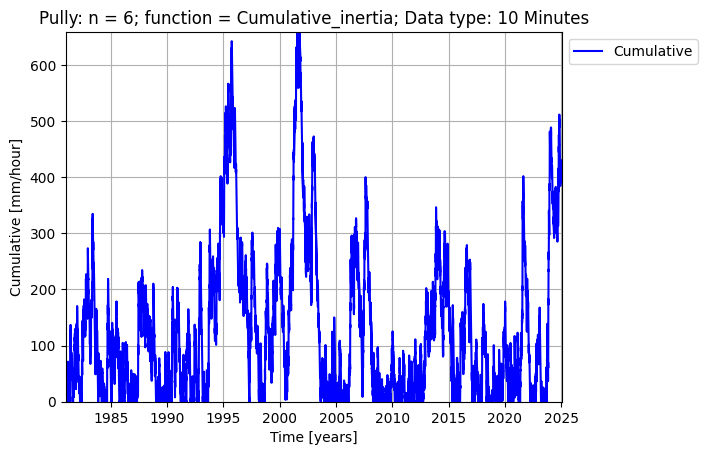

In [19]:
fct = Cumulative_inertia
cumulative = fct(time_serie, damping=0.17, inertia_ratio=0.0)

h_to_y = n/(ratio[temp]*24*365) #Convertis les heures en années
time = np.arange(0,len(cumulative)) * h_to_y + 1981

plt.figure()
plt.plot(time,cumulative,'b-',label=f'Cumulative')
plt.grid('on')
plt.ylim([-0.1,np.max(cumulative)+1])
plt.title(Station[num_sta]+f': n = {n}'+f'; function = '+fct.__name__+'; Data type: '+Temporalité2[temp])
#plt.xlim(2000,2002)
plt.xlim(np.min(time),np.max(time))
plt.xlabel(f'Time [years]')
plt.ylabel(f'Cumulative [mm/hour]')
plt.legend(loc = 'upper left', bbox_to_anchor=(1,1))
plt.savefig('test.svg')